# Cross-correlation and Autocorrelation in Pastas<a id="top"></a>

### Background
The `pastas.stats.ccf` function doesn't give the expected results. This is caused by the fact that in the calculation method, both the positive lag and negative lag are considered together. In autocorrelation this isn't a problem as the autocorrelation for all lags is symmetrical. For cross-correlation this is not necessarily the case. A change in the `ccf` function is proposed that only considers the positive lags. 

The original `pastas.stats.ccf` method also scales the calculated result by the absolute maximum of the calculated CCF. This means that regardless of how completely unsimilar two series are there is always a lag at which the correlation is given to be 1.0. This also seems dubious, therefore in the new implementation this step has been removed.

For series with constant timesteps the calculated correlations are compared to the results obtained through `numpy.correlate`. The calculated correlation is scaled so that the result is between -1.0 and 1.0. This same scaling is also applied in the pastas functions.

Note: the use of the number of overlapping elements to scale the result can lead to calculated correlations larger than 1.0, or to perfectly matching series having a correlation that is smaller than 1.0. This is caused by the fact that the two series are normalized at start of the calculation. When shifting one series relative to another, only the overlapping part of the series is considered and scaled by the number of overlapping elements. This overlapping part of the series might not satisfy the conditions of a normalized series ($\mu = 0$ and $\sigma = 1.0$). This means the maximum correlation of the overlapping parts can be either larger or smaller than the number of overlapping elements. When scaling by the number of overlapping elements this can yield correlations unequal to 1.0 for series that match one another perfectly. Thie effect is presumably smaller when the maximum lag << observation period and the total number of measurements is large.

### Table of contents
1. [Adjusted `pastas.stats.ccf` function](#1)
1. [Test data](#2)
1. [Helper functions](#3)
1. [Test new ACF (constant timesteps)](#4)
1. [Test new CCF (constant timesteps)](#5)
1. [Test new ACF (different timesteps)](#6)
1. [Test new CCF (different timesteps)](#7)


In [1]:
import numpy as np
import pandas as pd
from pandas import Timedelta, Series, DataFrame
import pastas as ps
import matplotlib.pyplot as plt

## 1. [Adjusted `pastas.stats.ccf` function](#top)<a id="1"></a>

In [2]:
def acf(x, lags=None, bin_method='gaussian', bin_width=None, max_gap=np.inf,
        min_obs=10, output="acf"):
    """Method to calculate the autocorrelation function for irregular
    timesteps based on the slotting technique. Different methods (kernels)
    to bin the data are available.

    Parameters
    ----------
    x: pandas.Series
        Pandas Series containig the values to calculate the
        cross-correlation for. The index has to be a Pandas.DatetimeIndex
    lags: numpy.array, optional
        numpy array containing the lags in days for which the
        cross-correlation if calculated. [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
        12, 13, 14, 30, 61, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
    bin_method: str, optional
        method to determine the type of bin. Options are "gaussian" (default),
        sinc and rectangle.
    bin_width: float, optional
        number of days used as the width for the bin to calculate the
        correlation. By default these values are chosed based on the
        bin_method.
    max_gap: float, optional
        Maximum timestep gap in the data. All timesteps above this gap value
        are not used for calculating the average timestep. This can be
        helpfull when there is a large gap in the data that influences the
        average timestep.

    Returns
    -------
    CCF: pandas.Series
        The Cross-correlation function.

    References
    ----------
    Rehfeld, K., Marwan, N., Heitzig, J., Kurths, J. (2011). Comparison
    of correlation analysis techniques for irregularly sampled time series.
    Nonlinear Processes in Geophysics. 18. 389-404. 10.5194 pg-18-389-2011.

    Examples
    --------
    acf = ps.stats.ccf(x, y, bin_method="gaussian")

    """
    C = ccf(x=x, y=x, lags=lags, bin_method=bin_method, bin_width=bin_width,
            max_gap=max_gap, min_obs=min_obs, output=output)
    C.name = "ACF"
    return C


def ccf(x, y, lags=None, bin_method='gaussian', bin_width=None,
        max_gap=np.inf, min_obs=10, output="ccf"):
    """Method to calculate the cross-correlation function for irregular
    timesteps based on the slotting technique. Different methods (kernels)
    to bin the data are available.

    Parameters
    ----------
    x, y: pandas.Series
        Pandas Series containig the values to calculate the
        cross-correlation for. The index has to be a Pandas.DatetimeIndex
    lags: numpy.array, optional
        numpy array containing the lags in days for which the
        cross-correlation if calculated. [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
        12, 13, 14, 30, 61, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
    bin_method: str, optional
        method to determine the type of bin. Options are "gaussian" (default),
        sinc and rectangle.
    bin_width: float, optional
        number of days used as the width for the bin to calculate the
        correlation. By default these values are chosed based on the
        bin_method.
    max_gap: float, optional
        Maximum timestep gap in the data. All timesteps above this gap value
        are not used for calculating the average timestep. This can be
        helpfull when there is a large gap in the data that influences the
        average timestep.

    Returns
    -------
    CCF: pandas.Series
        The Cross-correlation function.

    References
    ----------
    Rehfeld, K., Marwan, N., Heitzig, J., Kurths, J. (2011). Comparison
    of correlation analysis techniques for irregularly sampled time series.
    Nonlinear Processes in Geophysics. 18. 389-404. 10.5194 pg-18-389-2011.

    Examples
    --------
    acf = ps.stats.ccf(x, y, bin_method="gaussian")

    """
    # prepare the time indices for x and y
    dt_x = x.index.to_series().diff().values / Timedelta(1, "D")
    dt_x[0] = 0.0
    dt_x_mu = dt_x[dt_x < max_gap].mean()  # Deal with big gaps if present
    t_x = np.cumsum(dt_x)

    dt_y = y.index.to_series().diff().values / Timedelta(1, "D")
    dt_y[0] = 0.0
    dt_y_mu = dt_y[dt_y < max_gap].mean()
    t_y = np.cumsum(dt_y)

    dt_mu = max(dt_x_mu, dt_y_mu)

    # Create matrix with time differences
    t1, t2 = np.meshgrid(t_x, t_y)
    
    # Do not take absolute value and set values to nan where t < 0.
    # This means only positive lags can be calculated!
    t = np.subtract(t1, t2)
    t[t<0] = np.nan

    # Normalize the values and create numpy arrays
    x = (x.values - x.values.mean()) / x.values.std()
    y = (y.values - y.values.mean()) / y.values.std()

    # Create matrix for covariances
    xy = np.outer(y, x)

    if lags is None:  # Default lags in Days, log-scale between 0 and 365.
        lags = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 30, 61, 90, 120,
                150, 180, 210, 240, 270, 300, 330, 365]

    # Remove lags that cannot be determined because lag < dt_min
    u, i = np.unique(dt_x, return_counts=True)
    dt_x_min = u[Series(i, u).cumsum() >= min_obs][0]
    u, i = np.unique(dt_y, return_counts=True)
    dt_y_min = u[Series(i, u).cumsum() >= min_obs][0]

    dt_min = min(dt_x_min, dt_y_min)
    # dt_min = min(dt_x[1:].min(), dt_y[1:].min())

    lags = np.array([float(lag) for lag in lags if lag >= dt_min or lag == 0])

    # Delete to free memory
    del (x, y, dt_x, dt_y, t1, t2, t_x, t_y)

    # Select appropriate bin_width, default depend on bin_method
    if bin_width is None:
        options = {"rectangle": 0.5, "sinc": 1, "gaussian": 0.25}
        bin_width = np.ones_like(lags) * options[bin_method] * dt_mu
    elif type(bin_width) is float:
        bin_width = np.ones_like(lags)
    else:
        bin_width = [0.5, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5,
                     2, 2, 2, 2, 2, 2, 2, 2]

    # Select the binning method to calculate the cross-correlation
    if bin_method == "rectangle":
        a = np.zeros_like(t, dtype=float)
        kernel_func = lambda d, h: np.less_equal(np.abs(d, out=a), h,
                                                 out=a).astype(int)
    elif bin_method == "gaussian":
        a = np.zeros_like(t, dtype=float)

        def kernel_func(d, h):
            den1 = -2 * h ** 2  # denominator 1
            den2 = np.sqrt(2 * np.pi * h)  # denominator 2
            return np.exp(np.square(d, out=a) / den1, out=a) / den2
    elif bin_method == "sinc":
        kernel_func = lambda d, h: np.sin(np.pi * h * d) / (np.pi * h * d)
    else:
        raise NotImplementedError("bin_method %s is not implemented." %
                                  bin_method)

    # Pre-allocate an array to speed up all numpy methods
    UDCF = np.zeros_like(lags, dtype=float)
    M = np.zeros_like(lags, dtype=float)
    d = np.zeros_like(t, dtype=float)

    for i, k in enumerate(lags):
        # Construct the kernel for the lag
        np.subtract(t, k, out=d)
        h = bin_width[i]
        b = kernel_func(d, h)
        c = np.multiply(xy, b, out=d)  # Element-wise multiplication
        
        # Use nansum to avoid the NaNs that are now in these matrices
        UDCF[i] = np.nansum(c)
        M[i] = np.nansum(b)

    DCF = UDCF / M  # scale (by length of the overlap when bin_method="rectangle")
    C = Series(data=DCF, index=lags, name="CCF")
    CCF = C
    
    if output == "full":
        CCFstd = np.sqrt((np.cumsum(UDCF) - M * DCF) ** 2) / (M - 1)
        CCF = DataFrame(data={"CCF": CCF.values, "stderr": CCFstd}, index=lags)

    CCF.index.name = "Lags (Days)"
    return CCF

## 2. [Test data](#top)<a id="2"></a>

### 2 sines (equal timesteps)

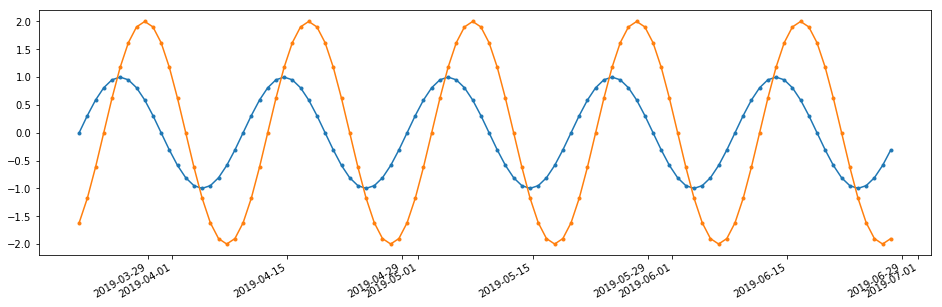

In [3]:
t = np.arange(0, 100)
T = 20.0/(2*np.pi)
lag = 3.0
custom_index = pd.date_range(pd.datetime.today(), periods=len(t))

s1 = pd.Series(index=custom_index, data=np.sin(t/T))
s2 = pd.Series(index=custom_index, data=2*np.sin(1*t/T - lag/T))

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
s1.plot(ax=ax, marker=".")
s2.plot(ax=ax, marker=".")

### 2 sines unequal timesteps

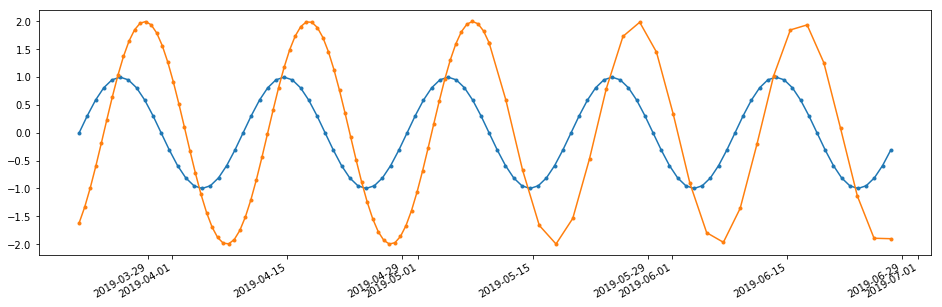

In [4]:
t1 = np.arange(0, 100)
t2 = np.r_[np.linspace(0, 50, 75), np.linspace(50, 99, 25)]

T = 20.0/(2*np.pi)
custom_index1 = pd.date_range(pd.datetime.today(), periods=len(t))
custom_index2 = []
for i, ti in enumerate(t2):
    custom_index2.append(custom_index1[0] + pd.DateOffset(days=ti))

custom_index2 = np.array(custom_index2)

s3 = pd.Series(index=custom_index1, data=np.sin(t1/T))
s4 = pd.Series(index=custom_index2, data=2*np.sin(1*t2/T - 3/T))

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
s3.plot(ax=ax, marker=".")
s4.plot(ax=ax, marker=".")

### 2 peaks (equal timesteps)

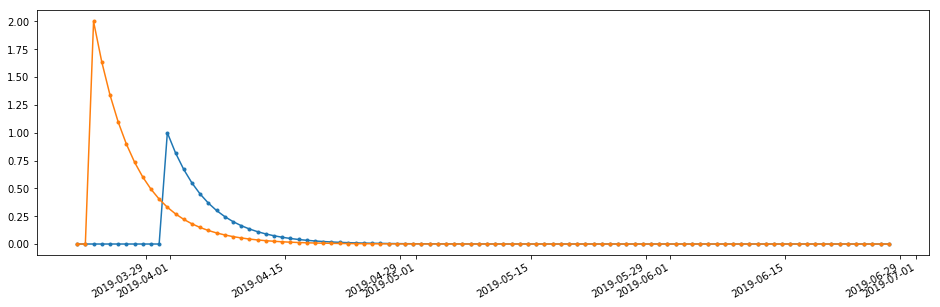

In [5]:
t = np.arange(0, 100)
custom_index = pd.date_range(pd.datetime.today(), periods=len(t))

lag1 = 11
lag2 = 2
alpha = 5.0

s5 = pd.Series(index=custom_index, data=np.zeros(len(t)))
to_timestep = len(s5.loc[custom_index1[0] + pd.Timedelta(days=lag1):])
s5.loc[custom_index[0] + pd.Timedelta(days=lag1):] = np.exp(-np.arange(len(t))/alpha)[:to_timestep]
s6 = pd.Series(index=custom_index, data=np.zeros(len(t)))
to_timestep = len(s6.loc[custom_index1[0] + pd.Timedelta(days=lag2):])
s6.loc[custom_index[0] + pd.Timedelta(days=lag2):] = 2*np.exp(-np.arange(len(t))/alpha)[:to_timestep]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
s5.plot(ax=ax, marker=".")
s6.plot(ax=ax, marker=".")

### 2 peaks (unequal timesteps)

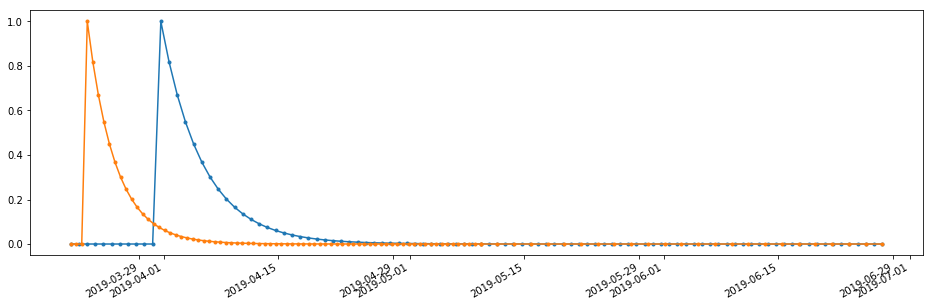

In [6]:
t1 = np.arange(0, 100)
t2 = np.r_[np.linspace(0, 50, 75), np.linspace(50, 99, 25)]
custom_index1 = pd.date_range(pd.datetime.today(), periods=len(t1))
custom_index2 = []

for ti in t2:
    custom_index2.append(custom_index1[0] + pd.DateOffset(days=ti))
custom_index2 = np.array(custom_index2)

lag1 = 11
lag2 = 2
alpha = 5.0

s7 = pd.Series(index=custom_index1, data=np.zeros(len(t1)))
to_timestep = len(s7.loc[custom_index1[0] + pd.Timedelta(days=lag1):])
s7.loc[custom_index1[0] + pd.Timedelta(days=lag1):] = np.exp(-np.arange(len(t1))/alpha)[:to_timestep]

s8 = pd.Series(index=custom_index2, data=np.zeros(len(t2)))
to_timestep = len(s8.loc[custom_index2[0] + pd.Timedelta(days=lag2):])
s8.loc[custom_index2[0] + pd.Timedelta(days=lag2):] = np.exp(-np.arange(len(t2))/alpha)[:to_timestep]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
s7.plot(ax=ax, marker=".")
s8.plot(ax=ax, marker=".")

## 3. [Create some helper functions to compare datasets](#top)<a id="3"></a>

In [7]:
def compare_acf_funcs(s1, lags=None, bin_method="rectangle", numpycorr=True, scale_w_max=False):
    s1n = (s1.values - s1.mean()) / s1.std()
    
    if numpycorr:
        overlap = np.r_[np.arange(1, len(s1)+1), np.arange(len(s1)-1, 0, -1)]

        ACF_np = np.correlate(s1n, s1n, mode="full") / overlap
        ACF_np = ACF_np[len(ACF_np)//2:]
        ACF_np = pd.Series(index=lags, data=ACF_np, name="ACF numpy")
    
    ACF_pastas = ps.stats.acf(s1, bin_method=bin_method, lags=lags)
    ACF_pastas.name = "ACF_orig"
    ACF_new = acf(s1, bin_method=bin_method, lags=lags)
    ACF_new.name = "ACF_new"
    if scale_w_max:
        ACF_new /= ACF_new.abs().max()
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    ax.plot(ACF_pastas.index, ACF_pastas, marker="o", label="Old Pastas ACF implementation")
    ax.plot(ACF_new.index, ACF_new, marker="x", label="Proposed Pastas ACF implementation")
    if numpycorr:
        ax.plot(lags, ACF_np, ls="dotted", marker="+", color="C3", label="Numpy ACF implementation")
    ax.legend(loc="best")
    ax.grid(b=True)
    ax.set_xlabel("Lags (days)")
    ax.set_ylabel("Autocorrelation (-)");
    if numpycorr:
        return pd.concat([ACF_pastas, ACF_new, ACF_np], axis=1)
    else:
        return pd.concat([ACF_pastas, ACF_new], axis=1)

def compare_ccf_funcs(s1, s2, lags=None, bin_method="rectangle", numpycorr=True, scale_w_max=False):
    s1n = (s1.values - s1.mean()) / s1.std()
    s2n = (s2.values - s2.mean()) / s2.std()
    if numpycorr:
        maxlen = np.amax([len(s1), len(s2)])
        overlap = np.r_[np.arange(1, len(s2)+1), len(s2)*np.ones(len(s1)-len(s2)), np.arange(len(s2)-1, 0, -1)]
        CCF_np = np.correlate(s1n, s2n, mode="full") / overlap
        CCF_np = CCF_np[len(CCF_np)//2:]
        CCF_np = pd.Series(index=lags, data=CCF_np, name="CCF numpy")

    CCF_pastas = ps.stats.ccf(s1, s2, bin_method=bin_method, lags=lags)
    CCF_pastas.name = "CCF_orig"
    CCF_new = ccf(s1, s2, bin_method=bin_method, lags=lags)
    CCF_new.name = "CCF_new"
    if scale_w_max:
        CCF_new /= CCF_new.abs().max()
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    ax.plot(CCF_pastas.index, CCF_pastas, marker="o", label="Old Pastas CCF implementation")
    ax.plot(CCF_new.index, CCF_new, marker="x", label="Proposed new Pastas CCF implementation")
    if numpycorr:
        ax.plot(lags, CCF_np, ls="dotted", marker="+", label="Numpy CCF implementation")
    ax.grid(b=True)
    ax.legend(loc="best")
    ax.set_xlabel("Lags (days)")
    ax.set_ylabel("Cross-correlation (-)")
    if numpycorr:
        return pd.concat([CCF_pastas, CCF_new, CCF_np], axis=1)
    else:
        return pd.concat([CCF_pastas, CCF_new], axis=1)

def plot_at_lag(s1, s2, lag=0):
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    ax.plot(s1.index, s1, marker="o", label="Series 1")
    ax.plot(s2.shift(lag).index, s2.shift(lag), marker=".", label="Series 2")
    ax.grid(b=True)
    ax.legend(loc="best")
    
    return ax

def corrplot_at_lag(s1, s2, lag=0):
    shifts2 = s2.shift(lag).dropna()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.plot(s1.loc[shifts2.index], shifts2, marker=".", ls="")
    ax.set_xlabel("Series 1")
    ax.set_ylabel("Series 2")
    ax.grid(b=True)
    
    return ax

## 4. [Test new ACF (constant timesteps)](#top)<a id="4"></a>
Test whether the new implementation of `pastas.stats.ccf` yields the same result as the old `pastas.stats.acf` function.

C:\Users\dbrak\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in less_equal


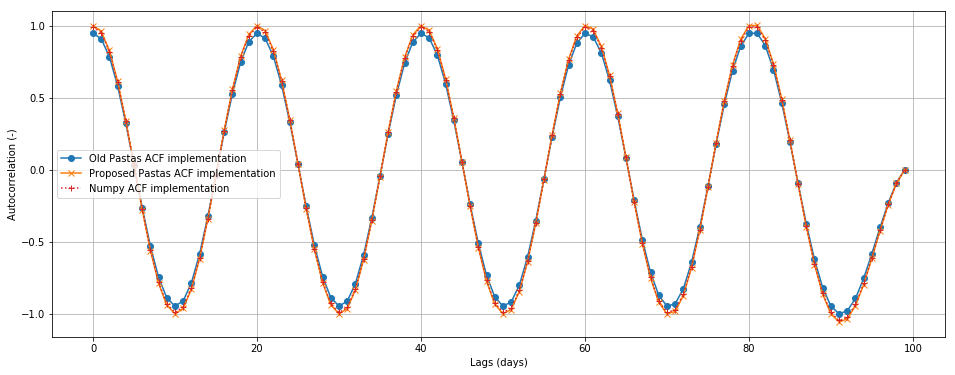

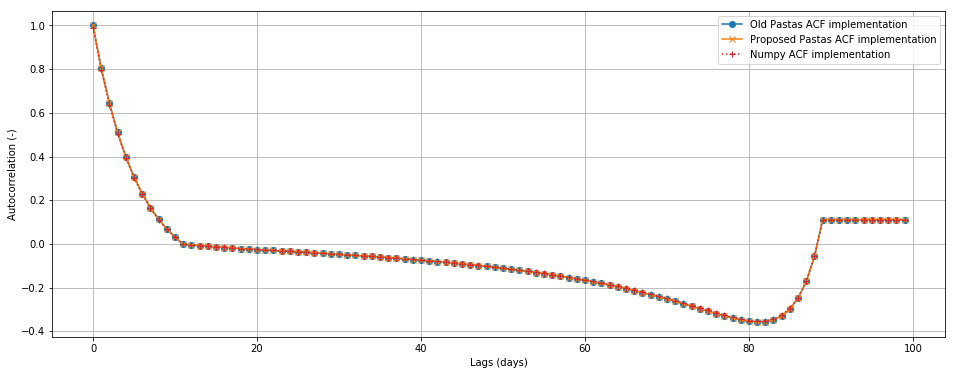

In [8]:
for s in [s1, s5]:
    acfdf = compare_acf_funcs(s, lags=np.arange(0, len(s)))

## 5. [Test new CCF (constant timesteps)](#top)<a id="5"></a>

The original implementation of `pastas.stats.ccf` is incorrect as it combines the correlation of both the negative and positive lags at the same time. In the example of the sine waves it can be seen that the original pastas.stats.ccf function results in a correlation of 1.0 at lag=0. This is obviously incorrect as the sines were shifted relative to one another.

For constant timesteps it is possible to compare the result with `numpy.correlate`. As can be seen, the new implementation of `ccf` yields the exact same result as numpy.

C:\Users\dbrak\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in less_equal


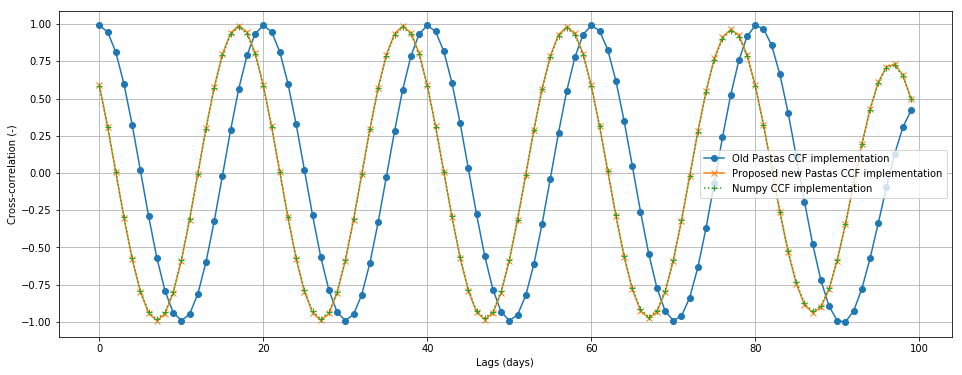

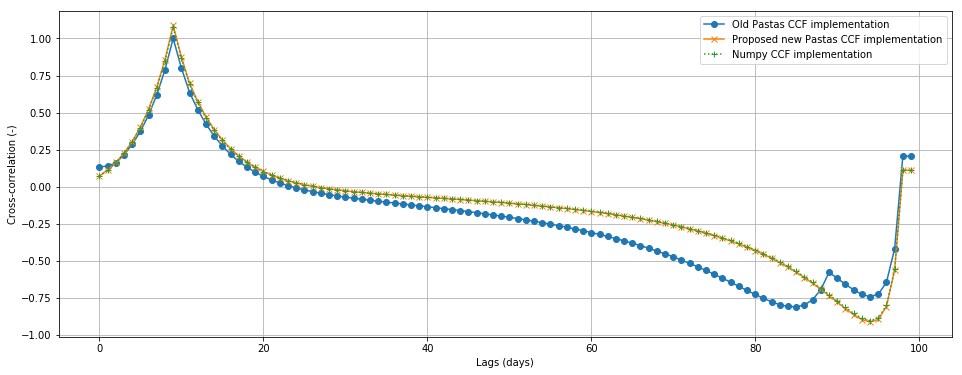

In [9]:
for (s, ss) in [(s1, s2), (s5, s6)]:
    ccfdf = compare_ccf_funcs(s, ss, lags=np.arange(0, 100))
    ccfdf.head()

## 6. [Test new ACF (uneven timesteps)](#top)<a id="6"></a>

C:\Users\dbrak\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in less_equal


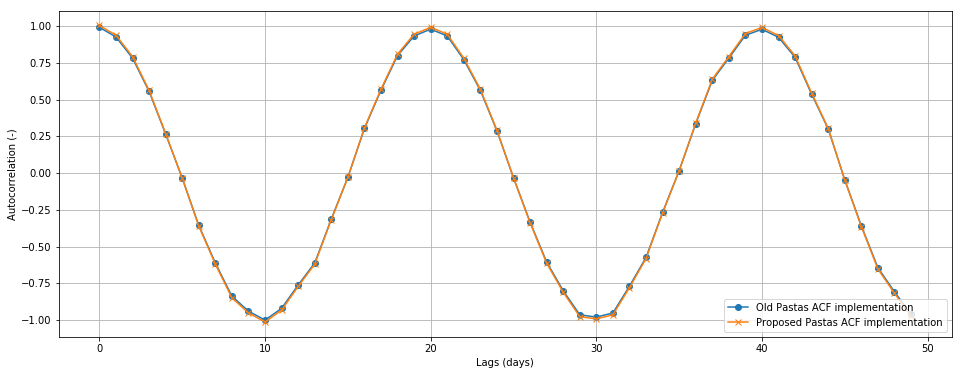

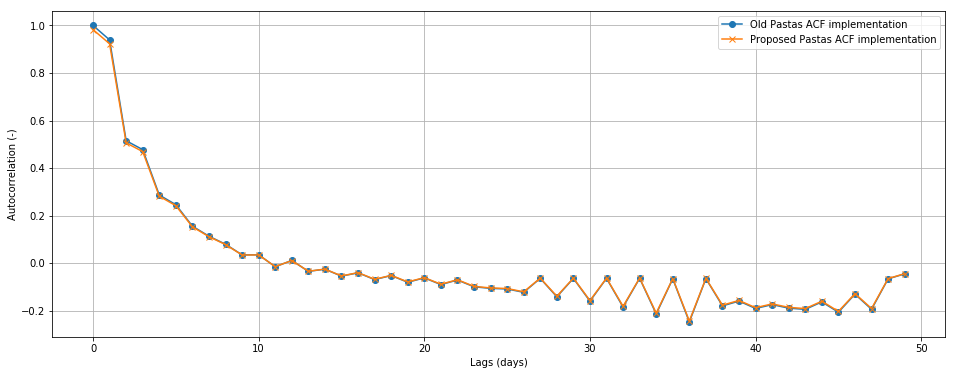

In [10]:
for s in [s4, s8]:
    compare_acf_funcs(s, lags=np.arange(50), numpycorr=False, bin_method="rectangle")

## 7. [Test new CCF (different timesteps)](#top)<a id="7"></a>

The old Pastas method gets the lags at which maximum correlations occur wrong. The new method performs better in this regard. In the case of the shifted peaks, the new method correctly identifies the lag at which the maximum correlation occurs but the value of the correlation is larger than 1.0. The old pastas method scaled the result by the absolute maximum of the calculated correlation series. Perhaps this should be an option?

C:\Users\dbrak\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in less_equal


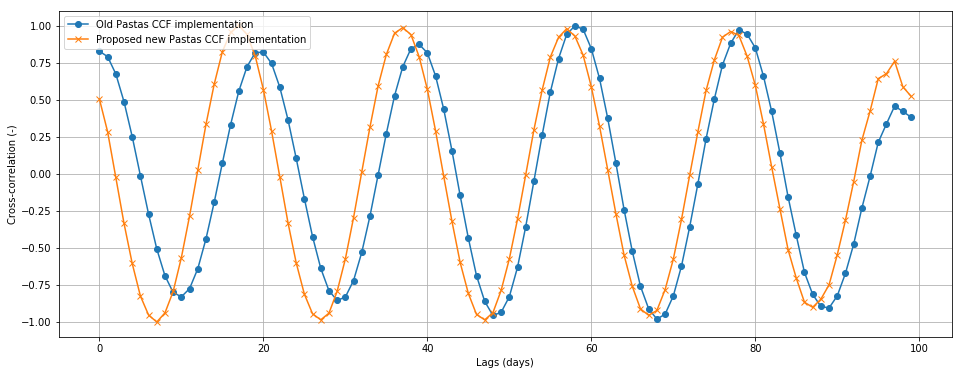

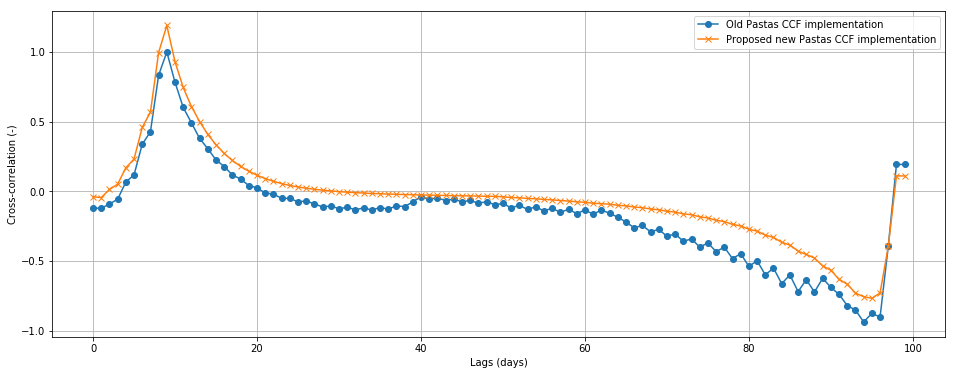

In [11]:
for (s, ss) in [(s3, s4), (s7, s8)]:
    ccfdf = compare_ccf_funcs(s, ss, lags=np.arange(0, 100), numpycorr=False, bin_method="rectangle", scale_w_max=False)